## Imports

In [1]:
import os
import sys
sys.path.append('../')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as pltpatch
import seaborn as sns
import torch
import cv2 as cv
import scipy.optimize
from tqdm import tqdm

from streetstudy.data import virat
from streetstudy.common import display
from streetstudy.model import yolo
from streetstudy.common import evaluation

## Load Data

In [2]:
# Get video data
video_df = virat.get_dataset_df()
video_df.head()

path  \
name                                                                                 
VIRAT_S_010204_03_000606_000632  /home/sardarchitect/datasets/virat/videos/VIRA...   

                                 num_frames  duration  image_width  \
name                                                                 
VIRAT_S_010204_03_000606_000632         400        16       1280.0   

                                 image_height  \
name                                            
VIRAT_S_010204_03_000606_000632         720.0   

                                                                        event_file  \
name                                                                                 
VIRAT_S_010204_03_000606_000632  VIRAT_S_010204_03_000606_000632.viratdata.even...   

                                                                       object_file  \
name                                                                                 
VIRAT_S_010204_03_000606_000632  VIRAT_S_010204_03_000606_000632.viratdata.obje...   

                                                                      mapping_file  
name                                                                                
VIRAT_S_010204_03_000606_000632  VIRAT_S_010204_03_000606_000632.viratdata.mapp...

In [4]:
# Select a video
current_video = video_df.loc['VIRAT_S_010204_03_000606_000632']

In [5]:
# Get annotations from selected video (VIRAT format)
objects_df = virat.get_annotations_df(current_video["path"], format='yolo', normalize=False, object_id=True)
events_df = virat.get_annotations_df(current_video["path"], type='events')

objects_df.sort_values('current_frame', inplace=True)
events_df.sort_values('current_frame', inplace=True)

In [6]:
objects_df.head()

current_frame  object_id  object_type  bbox_center_x  bbox_center_y  \
273               0          2            0          206.5          243.0   
3095              0         14            0          324.0          264.5   
4061              0         17            0          159.0          231.0   
1173              0          5            0          223.5          239.0   
2388              0         11            0          162.5          274.5   

      bbox_width  bbox_height  
273           23           42  
3095          24           57  
4061          16           18  
1173          17           30  
2388          27           59

In [7]:
events_df.head()

event_id  event_type  duration  start_frame  end_frame  current_frame  \
0         4           9        70            0         69              0   
1         4           9        70            0         69              1   
2         4           9        70            0         69              2   
3         4           9        70            0         69              3   
4         4           9        70            0         69              4   

   bbox_lefttop_x  bbox_lefttop_y  bbox_width  bbox_height  bbox_center_x  \
0             817             438         136          267          885.0   
1             821             441         134          264          888.0   
2             824             443         136          264          892.0   
3             828             444         134          264          895.0   
4             831             446         136          264          899.0   

   bbox_center_y  
0          571.5  
1          573.0  
2          575.0  
3          576.0  
4          578.0

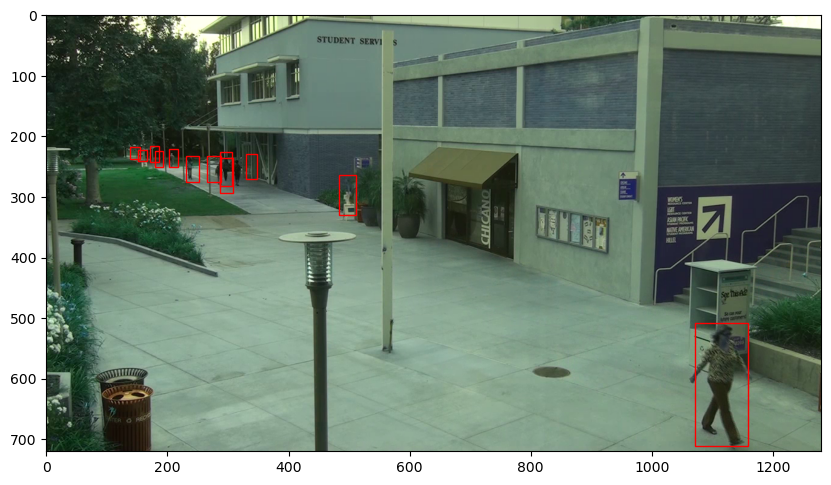

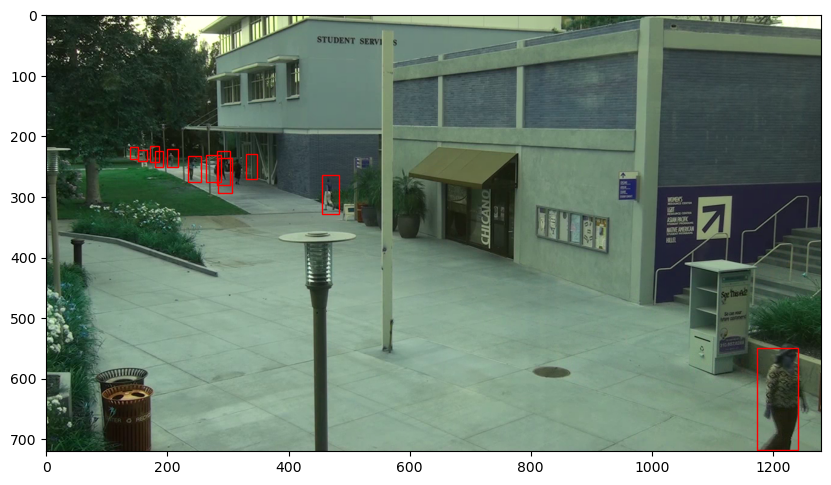

In [8]:
# View data to see some annotated frames
display.display_annotated_frame(current_video["path"], objects_df, 180)
display.display_annotated_frame(current_video["path"], objects_df, 200)

## Load Pretrained Model

In [9]:
model = yolo.yolov5()

Using cache found in /home/sardarchitect/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-6-3 Python-3.11.3 torch-2.0.1 CUDA:0 (NVIDIA GeForce GTX 1650, 4096MiB)

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


In [10]:
#preds = yolo.predict_video(model, current_video['path'], is_df=True)
#preds.head()

total_precision = []
total_recall = []
for current_frame in range(current_video['num_frames']):
    bbox_pred = preds[preds['current_frame'] == current_frame]
    bbox_gt = annotations_df[annotations_df['current_frame'] == current_frame]
    
    bbox_gt_match, bbox_pred_match, bbox_pred_ious, bbox_pred_labels = evaluation.match_bboxes(bbox_gt, bbox_pred)
    precision, recall = evaluation.precision_recall(bbox_gt, bbox_pred, bbox_pred_labels)
    total_precision.append(precision)
    total_recall.append(recall)

average_precision = sum(total_precision) / len(total_precision)
average_recall = sum(total_recall) / len(total_recall)

print(average_precision)
print(average_recall)

## Organize Directories

In [11]:
# See 20230512_YOLO Format Conversion.ipynb to see code for converting VIRAT data directories to YOLO format

## Train

In [12]:
#!python ../yolov5/train.py --img 640 --batch 16 --epochs 3 --data ../scripts/dataset.yaml --cfg ../scripts/yolov5s.yaml --weights yolov5s.pt --name streetstudy --cache

## Test

In [13]:
pass

## Postprocessing

### Pedestrian Count

In [14]:
pedestrian_count = objects_df['object_id'].unique()
print(len(pedestrian_count))

18


### Video Duration

In [15]:
print(current_video['duration'], "seconds")

16 seconds


### Footpath Density

In [16]:
%matplotlib inline

In [17]:
import glob
from PIL import Image

def make_gif(frame_folder):
    frames = [Image.open(image) for image in glob.glob(f"{frame_folder}/*.png")]
    frame_one = frames[0]
    frame_one.save("outputs/heatmap.gif", format="GIF", append_images=frames, save_all=True, duration=200, loop=0)

def display_heatmap_gif(video_path, annotations_df):
    capture = cv.VideoCapture(video_path)
    total_frame_numbers = int(capture.get(cv.CAP_PROP_FRAME_COUNT))
    
    sel_frames = [x for x in range(0, total_frame_numbers, total_frame_numbers//60)]
    i = 0
    while True:
        success, frame = capture.read()
        if not success:
            break
        current_frame_number = int(capture.get(cv.CAP_PROP_POS_FRAMES))
        if current_frame_number in sel_frames:
            current_frame_annotations = annotations_df[annotations_df['current_frame'] < current_frame_number]
            i += 1
            display.display_heatmap(current_frame_annotations, frame, save_path=f"outputs/{current_frame_number}.png")

# display_heatmap_gif(current_video['path'], annotations_df)
# make_gif('outputs')

In [18]:
events_df

event_id  event_type  duration  start_frame  end_frame  ...  \
0           4           9        70            0         69  ...   
1           4           9        70            0         69  ...   
2           4           9        70            0         69  ...   
3           4           9        70            0         69  ...   
4           4           9        70            0         69  ...   
..        ...         ...       ...          ...        ...  ...   
282         5           9       215          185        399  ...   
323         6           9        40          360        399  ...   
283         5           9       215          185        399  ...   
284         5           9       215          185        399  ...   
324         6           9        40          360        399  ...   

     bbox_lefttop_y  bbox_width  bbox_height  bbox_center_x  bbox_center_y  
0               438         136          267          885.0          571.5  
1               441         134          264          888.0          573.0  
2               443         136          264          892.0          575.0  
3               444         134          264          895.0          576.0  
4               446         136          264          899.0          578.0  
..              ...         ...          ...            ...            ...  
282             233          50           79          378.0          272.5  
323             259          62           96          119.0          307.0  
283             233          50           79          378.0          272.5  
284             235          50           78          378.0          274.0  
324             259          60           96          123.0          307.0  

[325 rows x 12 columns]

<Figure size 1000x800 with 0 Axes>

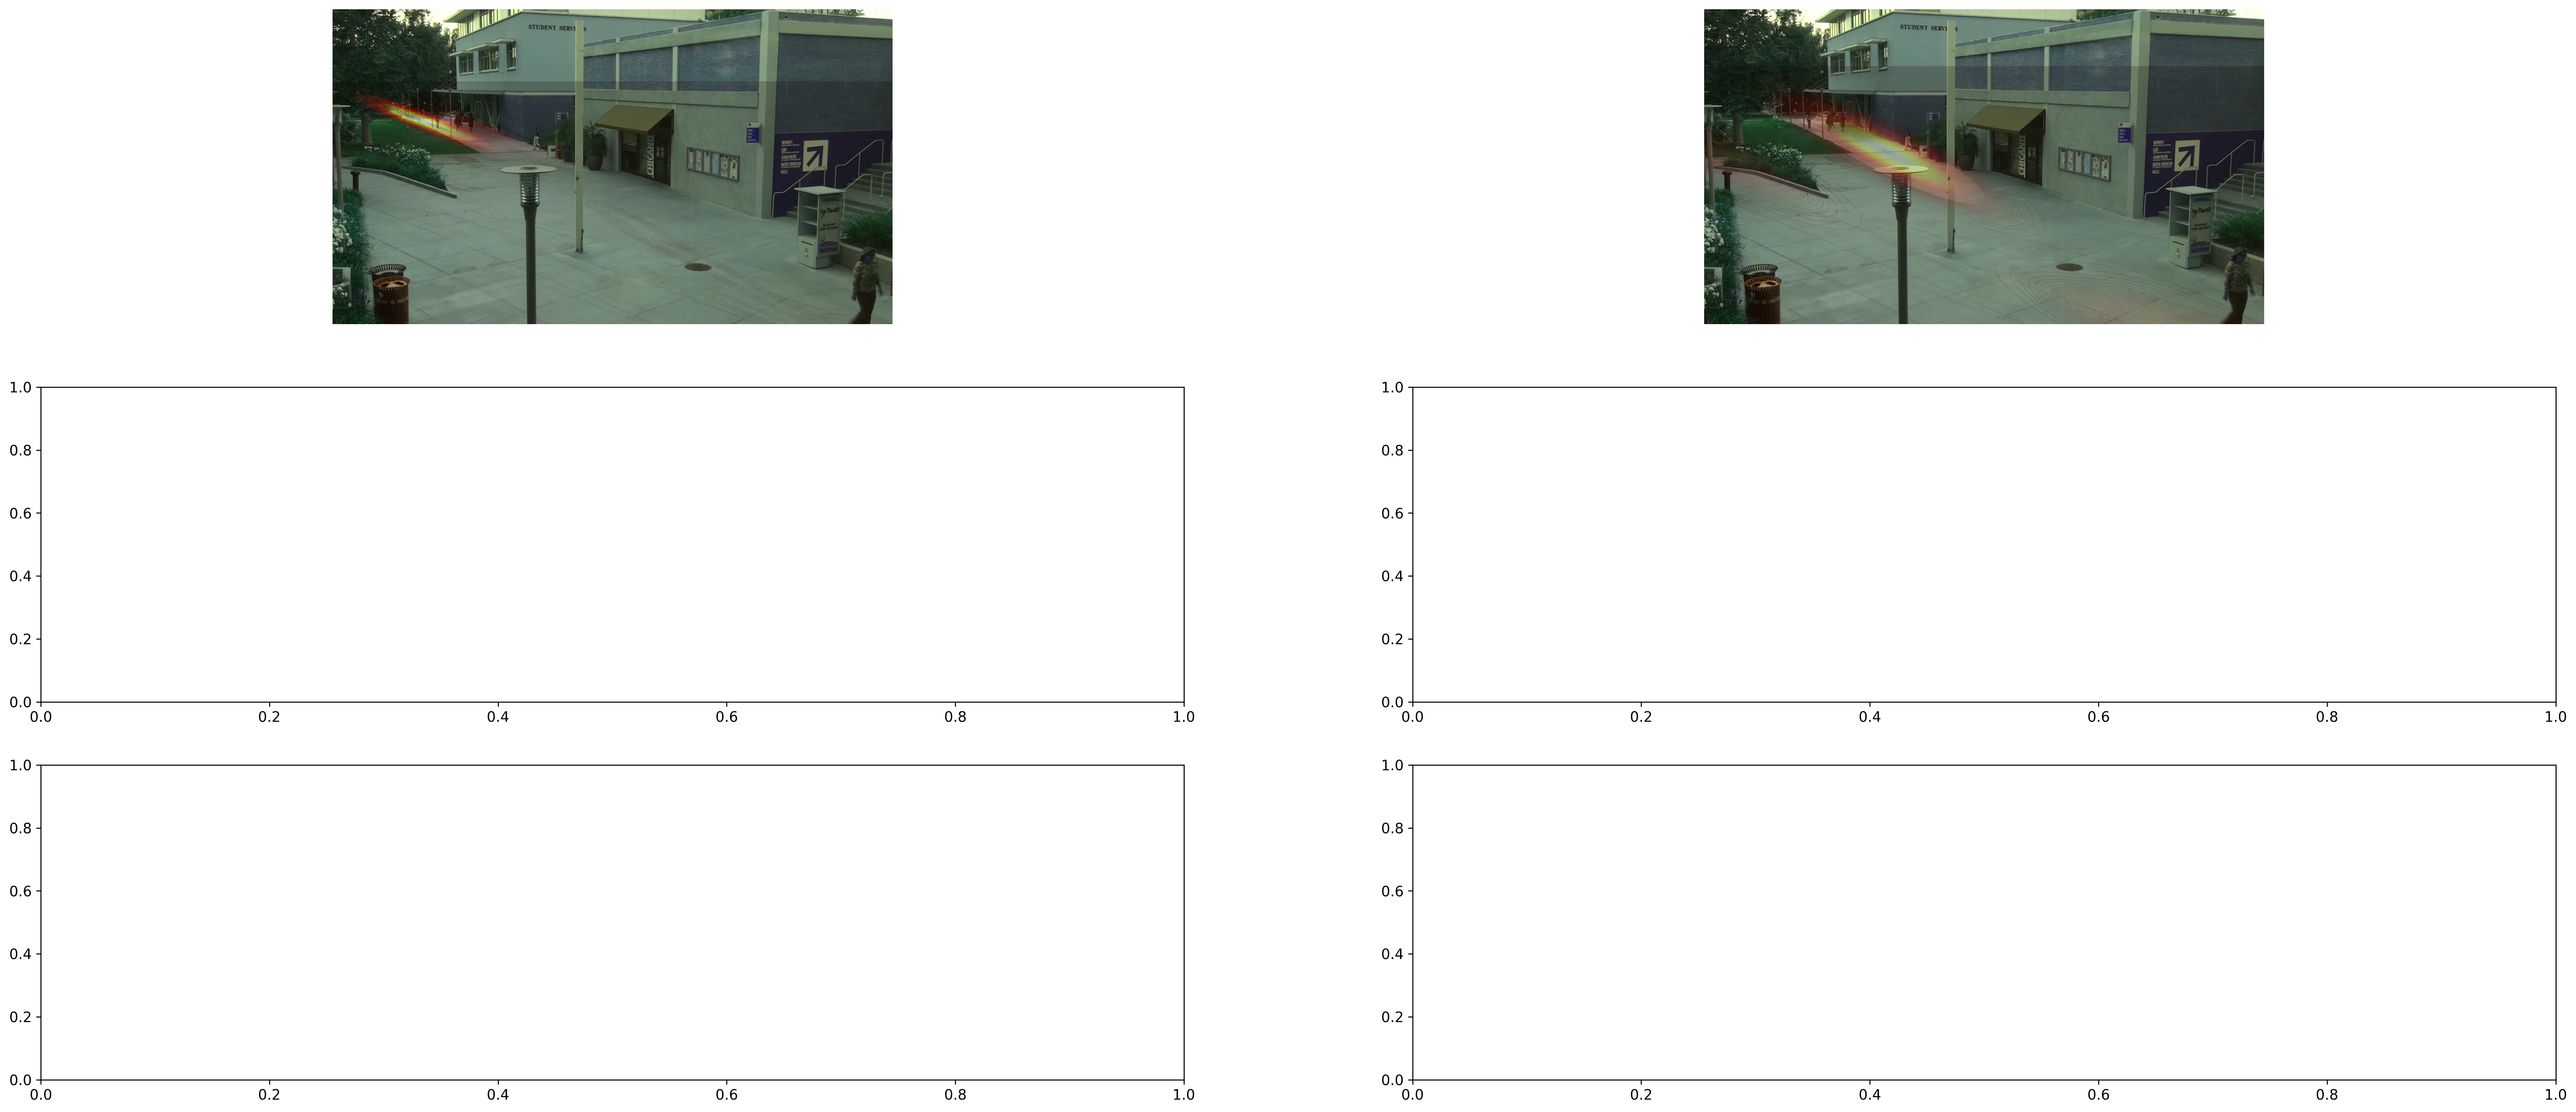

In [19]:
capture = cv.VideoCapture(current_video['path'])
while True:
    success, frame = capture.read()
    if not success:
        break
    current_frame_number = int(capture.get(cv.CAP_PROP_POS_FRAMES))
    if current_frame_number == 200:
        plt.figure(figsize=(10,8))
        fig, ax = plt.subplots(3, 2)
        ax[0][0] = display.display_heatmap(objects_df, frame, fig, ax[0][0])
        ax[0][1] = display.display_heatmap(events_df, frame, fig, ax[0][1])
        plt.show()

### Activity Density

In [20]:
events_df = virat.get_annotations_df(current_video['path'], type='events')
events_df.head()

event_id  event_type  duration  start_frame  end_frame  ...  \
0         4           9        70            0         69  ...   
1         4           9        70            0         69  ...   
2         4           9        70            0         69  ...   
3         4           9        70            0         69  ...   
4         4           9        70            0         69  ...   

   bbox_lefttop_y  bbox_width  bbox_height  bbox_center_x  bbox_center_y  
0             438         136          267          885.0          571.5  
1             441         134          264          888.0          573.0  
2             443         136          264          892.0          575.0  
3             444         134          264          895.0          576.0  
4             446         136          264          899.0          578.0  

[5 rows x 12 columns]

In [21]:
print(events_df['event_id'].unique())
print(events_df['event_type'].unique())
object_id_list = objects_df['object_id'].unique()

[4 5 6]
[9]


In [22]:
events_df['bbox_center_x'] = events_df['bbox_lefttop_x'] + (events_df['bbox_width'] / 2)
events_df['bbox_center_y'] = events_df['bbox_lefttop_y'] + (events_df['bbox_height'] / 2)
events_df.head()

event_id  event_type  duration  start_frame  end_frame  ...  \
0         4           9        70            0         69  ...   
1         4           9        70            0         69  ...   
2         4           9        70            0         69  ...   
3         4           9        70            0         69  ...   
4         4           9        70            0         69  ...   

   bbox_lefttop_y  bbox_width  bbox_height  bbox_center_x  bbox_center_y  
0             438         136          267          885.0          571.5  
1             441         134          264          888.0          573.0  
2             443         136          264          892.0          575.0  
3             444         134          264          895.0          576.0  
4             446         136          264          899.0          578.0  

[5 rows x 12 columns]

### Directions

TypeError: Image data of dtype object cannot be converted to float

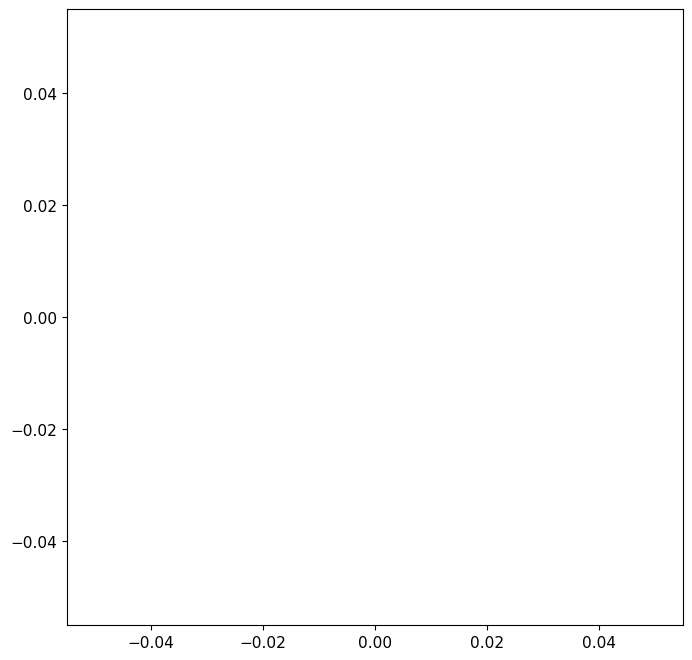

In [23]:
obj_df = objects_df[objects_df['object_id'] == object_id_list[5]]
x = obj_df['bbox_center_x']
y = obj_df['bbox_center_y'] + (obj_df['bbox_height'] / 2)

fig = plt.figure(figsize=(16,8))
step = 25
i = 0
while True:
    if i+step >= len(x):
        break
    X = x.iloc[i]
    Y = y.iloc[i]
    X_next = x.iloc[i + step]
    Y_next = y.iloc[i + step]
    dX = X_next - X
    dY = Y_next - Y
    
    plt.arrow(X, Y, dX, dY, length_includes_head=True, head_starts_at_zero=True, head_width=10)
    plt.gca().invert_yaxis()
    i = i + step
plt.imshow(frame)


### Individual Paths

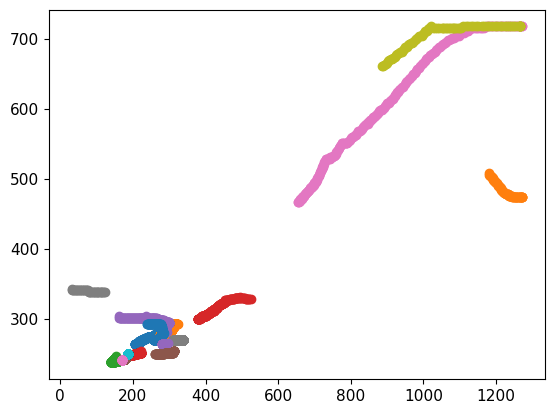

In [24]:
def person_path(object_id, annotations_df):
    obj_df = objects_df[objects_df['object_id'] == obj]
    feet_x = obj_df['bbox_center_x']
    feet_y = obj_df['bbox_center_y'] + (obj_df['bbox_height'] / 2)
    
#     fig, ax = plt.subplots()
    plt.scatter(feet_x, feet_y)
    plt.gca().invert_yaxis()
                            
object_id_list = objects_df['object_id'].unique()
for obj in object_id_list:
    person_path(obj, objects_df)
    
# Color based on activity 
# Add some filtering options so user can decide what they want to see


### Dwell Times